## Flight Price Prediction

## Problem Statement:

## Importing the required libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler,power_transform,LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset:

In [2]:
df = pd.read_csv("flights_df_final.csv")

In [3]:
df.drop("Unnamed: 0",axis =1,inplace = True) #dropping the duplicate row column

In [4]:
df.head()

,Airline,Date,Source City,Destination City,Departure Time,Arrival Time,Duration,Stops,Price
0,Air Asia,13-10-2021,Mumbai,Kolkata,23:05,07:00\n+ 1 day,7h 55m,1 Stop,"7,410"
1,Air Asia,13-10-2021,Mumbai,Kolkata,20:50,08:15\n+ 1 day,11h 25m,1 Stop,"7,410"
2,Air Asia,13-10-2021,Mumbai,Kolkata,05:55,21:20,15h 25m,2 Stop(s),"7,410"
3,SpiceJet,13-10-2021,Mumbai,Kolkata,05:05,07:40,2h 35m,Non Stop,"7,412"
4,Go First,13-10-2021,Mumbai,Kolkata,07:40,10:20,2h 40m,Non Stop,"7,412"


In [5]:
df.shape

(1611, 9)

## EDA (Exploratory Data Analysis)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Airline           1611 non-null   object
 1   Date              1611 non-null   object
 2   Source City       1611 non-null   object
 3   Destination City  1611 non-null   object
 4   Departure Time    1611 non-null   object
 5   Arrival Time      1611 non-null   object
 6   Duration          1611 non-null   object
 7   Stops             1611 non-null   object
 8   Price             1611 non-null   object
dtypes: object(9)
memory usage: 113.4+ KB


In [7]:
df.shape

(1611, 9)

Now we have 1611 rows and 9 columns

In [8]:
df.columns

Index(['Airline', 'Date', 'Source City', 'Destination City', 'Departure Time',
       'Arrival Time', 'Duration', 'Stops', 'Price'],
      dtype='object')

In [9]:
df.dtypes

Airline             object
Date                object
Source City         object
Destination City    object
Departure Time      object
Arrival Time        object
Duration            object
Stops               object
Price               object
dtype: object

In [10]:
#lets check for null values
df.isnull().sum()

Airline             0
Date                0
Source City         0
Destination City    0
Departure Time      0
Arrival Time        0
Duration            0
Stops               0
Price               0
dtype: int64

In [11]:
#lets print out the columns with unique values
for i in df.columns:
    if df[i].dtype == 'object':
        print(i,len(pd.unique(df[i])))

Airline 6
Date 15
Source City 5
Destination City 5
Departure Time 138
Arrival Time 142
Duration 185
Stops 4
Price 120


In [12]:
#lets print out the columns with unique values
for i in df.columns:
    if df[i].dtype == 'object':
        print('\n')
        print(i,df[i].value_counts())



Airline IndiGo       476
Air India    368
Vistara      367
Go First     139
Air Asia     137
SpiceJet     124
Name: Airline, dtype: int64


Date 13-10-2021    263
15-10-2021    243
14-10-2021    243
16-10-2021    243
17-10-2021     99
19-10-2021     99
18-10-2021     99
20-10-2021     74
21-10-2021     74
22-10-2021     49
25-10-2021     25
23-10-2021     25
26-10-2021     25
24-10-2021     25
27-10-2021     25
Name: Date, dtype: int64


Source City Lucknow      395
Bangalore    381
New Delhi    335
Mumbai       260
Jaipur       240
Name: Source City, dtype: int64


Destination City Goa          395
Chennai      381
Hyderabad    335
Kolkata      260
Pune         240
Name: Destination City, dtype: int64


Departure Time 15:25    82
08:05    60
07:10    46
06:40    43
08:00    41
         ..
20:25     1
17:35     1
15:30     1
07:55     1
21:45     1
Name: Departure Time, Length: 138, dtype: int64


Arrival Time 11:35\n+ 1 day    75
07:15\n+ 1 day    55
08:40\n+ 1 day    44
23:35      

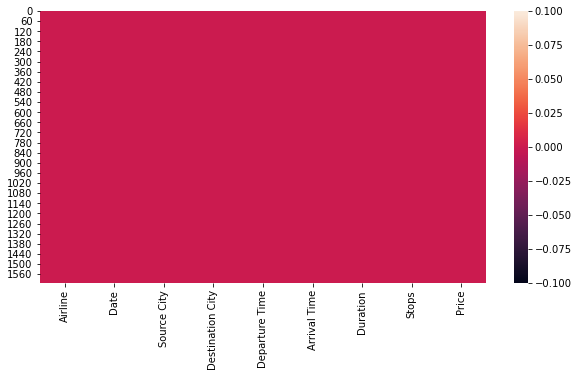

In [13]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull())
plt.show()

## Data Preprocessing

In [14]:
df['Dates'] =  pd.to_datetime(df['Date'],format="%d-%m-%Y")  #converting to date datatype

In [15]:
pd.DatetimeIndex(df['Dates']).month.unique()

Int64Index([10], dtype='int64', name='Dates')

In [16]:
#Dropping the old date column
df.drop("Date",axis =1 ,inplace = True)

In [17]:
df.head()

,Airline,Source City,Destination City,Departure Time,Arrival Time,Duration,Stops,Price,Dates
0,Air Asia,Mumbai,Kolkata,23:05,07:00\n+ 1 day,7h 55m,1 Stop,"7,410",2021-10-13
1,Air Asia,Mumbai,Kolkata,20:50,08:15\n+ 1 day,11h 25m,1 Stop,"7,410",2021-10-13
2,Air Asia,Mumbai,Kolkata,05:55,21:20,15h 25m,2 Stop(s),"7,410",2021-10-13
3,SpiceJet,Mumbai,Kolkata,05:05,07:40,2h 35m,Non Stop,"7,412",2021-10-13
4,Go First,Mumbai,Kolkata,07:40,10:20,2h 40m,Non Stop,"7,412",2021-10-13


In [18]:
#converting price to float
df['Price']= df.Price.str.replace(",","")

In [19]:
#lets convert the price to float datatype
df['Price']= df['Price'].astype("float64")

In [20]:
df.dtypes

Airline                     object
Source City                 object
Destination City            object
Departure Time              object
Arrival Time                object
Duration                    object
Stops                       object
Price                      float64
Dates               datetime64[ns]
dtype: object

In [21]:
#Converting duration columns to minutes 

def minutes(x):
    hour, minute = x.split("h")
    minutes = (60 * int(hour)) + int(minute.strip("m"))
    return float(minutes)

In [22]:
#applying the above function
df['Duration_in_Minutes'] = df.Duration.apply(minutes)

In [23]:
#dropping the old column
df.drop("Duration",axis = 1,inplace= True)

In [24]:
df.dtypes

Airline                        object
Source City                    object
Destination City               object
Departure Time                 object
Arrival Time                   object
Stops                          object
Price                         float64
Dates                  datetime64[ns]
Duration_in_Minutes           float64
dtype: object

In [25]:
def next_day(x):
    if "\n" in x:
        return "Yes"
    else:
        return "No"

In [26]:
#creating a new column using the existing information 
#if flight reaches the destination next day i.e after 12 am
df["Next_day_Arrival"] = df["Arrival Time"].apply(next_day)

In [27]:
df.head()

,Airline,Source City,Destination City,Departure Time,Arrival Time,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival
0,Air Asia,Mumbai,Kolkata,23:05,07:00\n+ 1 day,1 Stop,7410.0,2021-10-13,475.0,Yes
1,Air Asia,Mumbai,Kolkata,20:50,08:15\n+ 1 day,1 Stop,7410.0,2021-10-13,685.0,Yes
2,Air Asia,Mumbai,Kolkata,05:55,21:20,2 Stop(s),7410.0,2021-10-13,925.0,No
3,SpiceJet,Mumbai,Kolkata,05:05,07:40,Non Stop,7412.0,2021-10-13,155.0,No
4,Go First,Mumbai,Kolkata,07:40,10:20,Non Stop,7412.0,2021-10-13,160.0,No


In [28]:
import re
def Arrival(x):
    a = re.search(r"\d\d:\d\d",x)
    return a.group()

In [29]:

#removing the "\n+1 day" from arrival date
df["Arrival_Time"] = df["Arrival Time"].apply(Arrival)

In [30]:
#dropping the old column
df.drop("Arrival Time",axis = 1,inplace = True)
df.head()

,Airline,Source City,Destination City,Departure Time,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Arrival_Time
0,Air Asia,Mumbai,Kolkata,23:05,1 Stop,7410.0,2021-10-13,475.0,Yes,07:00
1,Air Asia,Mumbai,Kolkata,20:50,1 Stop,7410.0,2021-10-13,685.0,Yes,08:15
2,Air Asia,Mumbai,Kolkata,05:55,2 Stop(s),7410.0,2021-10-13,925.0,No,21:20
3,SpiceJet,Mumbai,Kolkata,05:05,Non Stop,7412.0,2021-10-13,155.0,No,07:40
4,Go First,Mumbai,Kolkata,07:40,Non Stop,7412.0,2021-10-13,160.0,No,10:20


In [31]:
#lets extract the departure hour from deaprture time column
df["Depature_hour"] = pd.to_datetime(df["Departure Time"])
df["Depature_hour"] = pd.DatetimeIndex(df['Depature_hour']).hour

In [32]:
#lets extract the Arrival hour from Arrival time column
df["Arrival_hour"] = pd.to_datetime(df["Arrival_Time"])
df["Arrival_hour"] = pd.DatetimeIndex(df['Arrival_hour']).hour

In [33]:
df.head()

,Airline,Source City,Destination City,Departure Time,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Arrival_Time,Depature_hour,Arrival_hour
0,Air Asia,Mumbai,Kolkata,23:05,1 Stop,7410.0,2021-10-13,475.0,Yes,07:00,23,7
1,Air Asia,Mumbai,Kolkata,20:50,1 Stop,7410.0,2021-10-13,685.0,Yes,08:15,20,8
2,Air Asia,Mumbai,Kolkata,05:55,2 Stop(s),7410.0,2021-10-13,925.0,No,21:20,5,21
3,SpiceJet,Mumbai,Kolkata,05:05,Non Stop,7412.0,2021-10-13,155.0,No,07:40,5,7
4,Go First,Mumbai,Kolkata,07:40,Non Stop,7412.0,2021-10-13,160.0,No,10:20,7,10


In [34]:
#now lets drop Arrival_time and deapture time
df.drop(["Arrival_Time","Departure Time"],axis =1, inplace = True)

In [35]:
df.head()

,Airline,Source City,Destination City,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Depature_hour,Arrival_hour
0,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,475.0,Yes,23,7
1,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,685.0,Yes,20,8
2,Air Asia,Mumbai,Kolkata,2 Stop(s),7410.0,2021-10-13,925.0,No,5,21
3,SpiceJet,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,155.0,No,5,7
4,Go First,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,160.0,No,7,10


In [36]:
#lets extract the time of the day from this column Dep_hour and Arrival_hour column
#lets write a function for this
def part_of_the_day(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [37]:
#applying the above fuction to get part of the day column
df['Departure_Part_of_the_day'] = df.Depature_hour.apply(part_of_the_day)

In [38]:
#applying the above fuction to get part of the day column
df['Arrival_Part_of_the_day'] = df.Arrival_hour.apply(part_of_the_day)

In [39]:
df.head()

,Airline,Source City,Destination City,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Depature_hour,Arrival_hour,Departure_Part_of_the_day,Arrival_Part_of_the_day
0,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,475.0,Yes,23,7,Night,Early Morning
1,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,685.0,Yes,20,8,Eve,Early Morning
2,Air Asia,Mumbai,Kolkata,2 Stop(s),7410.0,2021-10-13,925.0,No,5,21,Early Morning,Night
3,SpiceJet,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,155.0,No,5,7,Early Morning,Early Morning
4,Go First,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,160.0,No,7,10,Early Morning,Morning


In [272]:
#now lets drop Arrival_hour and deapture_hour
df.drop(["Arrival_hour","Depature_hour"],axis =1, inplace = True)

In [273]:
df.head()

,Airline,Source City,Destination City,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Departure_Part_of_the_day,Arrival_Part_of_the_day
0,Go First,New Delhi,Bangalore,Non Stop,7424.0,2021-10-09,155.0,No,Eve,Night
1,Go First,New Delhi,Bangalore,1 Stop,7424.0,2021-10-09,540.0,Yes,Night,Early Morning
2,Vistara,New Delhi,Bangalore,Non Stop,7425.0,2021-10-09,160.0,No,Eve,Night
3,SpiceJet,New Delhi,Bangalore,Non Stop,7425.0,2021-10-09,165.0,Yes,Night,Late Night
4,IndiGo,New Delhi,Bangalore,Non Stop,7425.0,2021-10-09,165.0,Yes,Night,Late Night


In [40]:

#exatrcting week number
df["week_num"] = pd.DatetimeIndex(df["Dates"]).weekday

In [41]:
#from Dates column we can extarct day and days prior to booking

def day(x):
    if x == 0:
        return "Monday"
    elif x == 1:
        return "Tuesday"
    elif x == 2:
        return "Wednesday"
    elif x == 3:
        return "Thursday"
    elif x == 4:
        return "Friday"
    elif x == 5:
        return "Saturday"
    elif x == 6:
        return "Sunday"

In [42]:
#extracting the day of the week
df["Day"] = df["week_num"].apply(day)

In [43]:
df.head()

,Airline,Source City,Destination City,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Depature_hour,Arrival_hour,Departure_Part_of_the_day,Arrival_Part_of_the_day,week_num,Day
0,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,475.0,Yes,23,7,Night,Early Morning,2,Wednesday
1,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,685.0,Yes,20,8,Eve,Early Morning,2,Wednesday
2,Air Asia,Mumbai,Kolkata,2 Stop(s),7410.0,2021-10-13,925.0,No,5,21,Early Morning,Night,2,Wednesday
3,SpiceJet,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,155.0,No,5,7,Early Morning,Early Morning,2,Wednesday
4,Go First,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,160.0,No,7,10,Early Morning,Morning,2,Wednesday


In [44]:
#exatracting only date since i have only scraped data from october 9th to october 31th 2021
df["only_date"] = pd.DatetimeIndex(df["Dates"]).day

In [45]:
#extraxting the days prior to booking column
#since i scapred the data on 9th
#for 9th days prior booking is zero
df["Days_priors_booking"] = df["only_date"] - 9

In [46]:
df.head()

,Airline,Source City,Destination City,Stops,Price,Dates,Duration_in_Minutes,Next_day_Arrival,Depature_hour,Arrival_hour,Departure_Part_of_the_day,Arrival_Part_of_the_day,week_num,Day,only_date,Days_priors_booking
0,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,475.0,Yes,23,7,Night,Early Morning,2,Wednesday,13,4
1,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,2021-10-13,685.0,Yes,20,8,Eve,Early Morning,2,Wednesday,13,4
2,Air Asia,Mumbai,Kolkata,2 Stop(s),7410.0,2021-10-13,925.0,No,5,21,Early Morning,Night,2,Wednesday,13,4
3,SpiceJet,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,155.0,No,5,7,Early Morning,Early Morning,2,Wednesday,13,4
4,Go First,Mumbai,Kolkata,Non Stop,7412.0,2021-10-13,160.0,No,7,10,Early Morning,Morning,2,Wednesday,13,4


In [47]:
#Now lets drop week_num,only_date,Dates columns
df.drop(["Dates","week_num","only_date"],axis =1,inplace= True)

In [48]:
df.head()

,Airline,Source City,Destination City,Stops,Price,Duration_in_Minutes,Next_day_Arrival,Depature_hour,Arrival_hour,Departure_Part_of_the_day,Arrival_Part_of_the_day,Day,Days_priors_booking
0,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,475.0,Yes,23,7,Night,Early Morning,Wednesday,4
1,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,685.0,Yes,20,8,Eve,Early Morning,Wednesday,4
2,Air Asia,Mumbai,Kolkata,2 Stop(s),7410.0,925.0,No,5,21,Early Morning,Night,Wednesday,4
3,SpiceJet,Mumbai,Kolkata,Non Stop,7412.0,155.0,No,5,7,Early Morning,Early Morning,Wednesday,4
4,Go First,Mumbai,Kolkata,Non Stop,7412.0,160.0,No,7,10,Early Morning,Morning,Wednesday,4


In [49]:
#This is Our final Dataframe after pre-Processing

In [50]:
#df.to_csv("Flights_final_pre.csv")

In [51]:
df

,Airline,Source City,Destination City,Stops,Price,Duration_in_Minutes,Next_day_Arrival,Depature_hour,Arrival_hour,Departure_Part_of_the_day,Arrival_Part_of_the_day,Day,Days_priors_booking
0,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,475.0,Yes,23,7,Night,Early Morning,Wednesday,4
1,Air Asia,Mumbai,Kolkata,1 Stop,7410.0,685.0,Yes,20,8,Eve,Early Morning,Wednesday,4
2,Air Asia,Mumbai,Kolkata,2 Stop(s),7410.0,925.0,No,5,21,Early Morning,Night,Wednesday,4
3,SpiceJet,Mumbai,Kolkata,Non Stop,7412.0,155.0,No,5,7,Early Morning,Early Morning,Wednesday,4
4,Go First,Mumbai,Kolkata,Non Stop,7412.0,160.0,No,7,10,Early Morning,Morning,Wednesday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,Vistara,Lucknow,Goa,2 Stop(s),14690.0,1210.0,Yes,15,11,Noon,Morning,Wednesday,18
1607,Vistara,Lucknow,Goa,2 Stop(s),14690.0,1210.0,Yes,15,11,Noon,Morning,Wednesday,18
1608,Vistara,Lucknow,Goa,2 Stop(s),14690.0,1210.0,Yes,15,11,Noon,Morning,Wednesday,18
1609,Vistara,Lucknow,Goa,2 Stop(s),14690.0,1210.0,Yes,15,11,Noon,Morning,Wednesday,18


## Data Visualization :

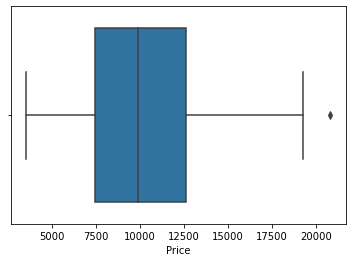

In [52]:
#lets check the box plot of our target column, to check if there are outliers
sns.boxplot(df.Price)
plt.show()

From the above plot we can see there is only 1 outlier in the target column

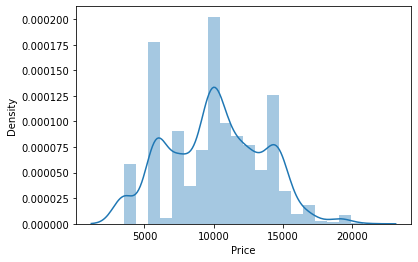

In [53]:
#lets check the distribution of the target column
sns.distplot(df.Price)
plt.show()

From the above plot we can see that data is less skewed in target column

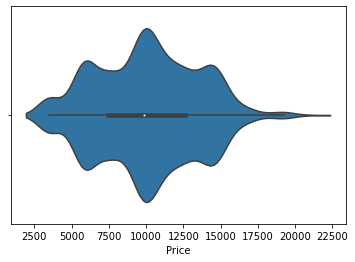

In [54]:
sns.violinplot(df.Price)
plt.show()

## Bivariate Analysis with Target Variable

In [55]:
df.columns

Index(['Airline', 'Source City', 'Destination City', 'Stops', 'Price',
       'Duration_in_Minutes', 'Next_day_Arrival', 'Depature_hour',
       'Arrival_hour', 'Departure_Part_of_the_day', 'Arrival_Part_of_the_day',
       'Day', 'Days_priors_booking'],
      dtype='object')

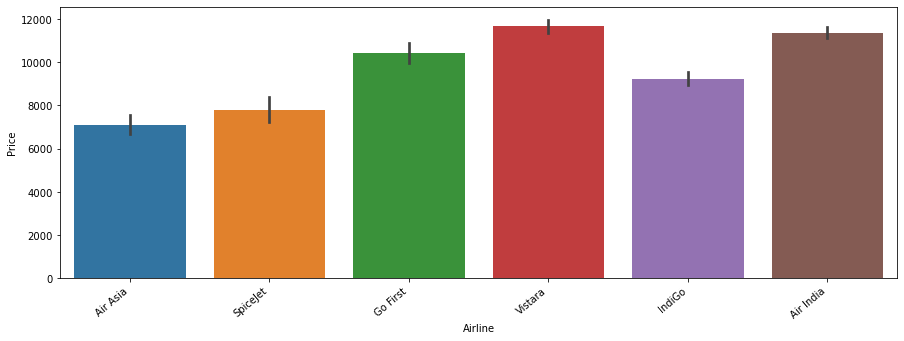

In [56]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Airline'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [57]:
#from the above plot we can see that AirAsia is very cheap and vistara is more expensive

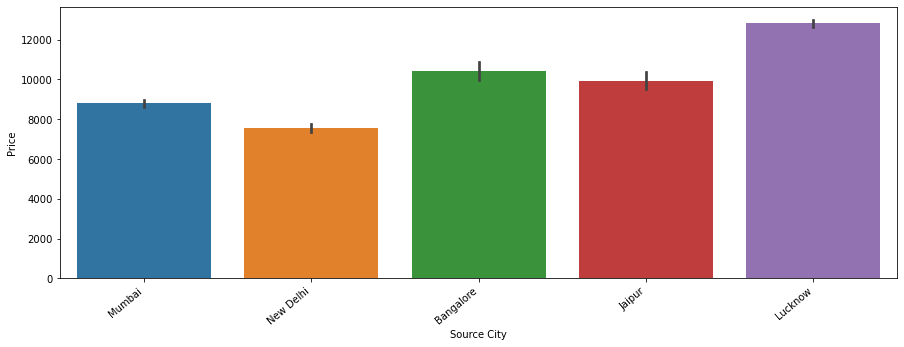

In [58]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Source City'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [1]:
#we can see that New Delhi have lowest prices and Lucknow have highest prices.

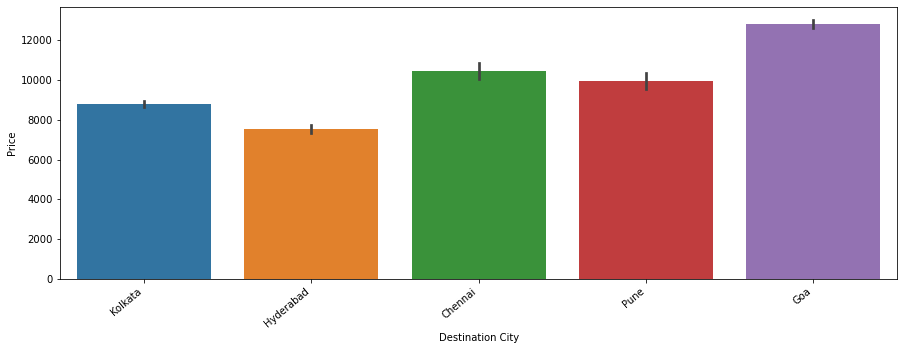

In [59]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Destination City'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [2]:
# we can see that Hyderabad have less prices and Goa have high prices

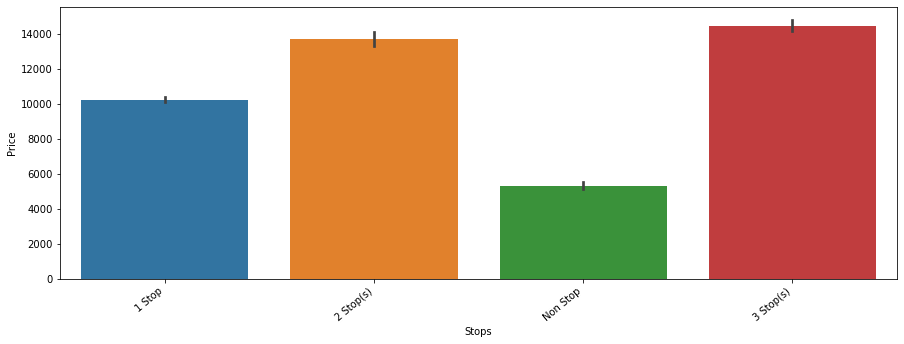

In [60]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Stops'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [61]:
#from the above plot we can see that flights having more spots are more expensive

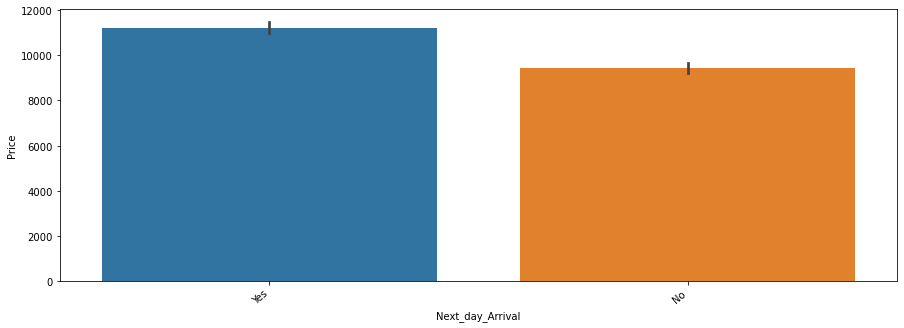

In [62]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Next_day_Arrival'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [63]:
#from the above plot we can see that if arrival is not in same day then the flight price is expensive

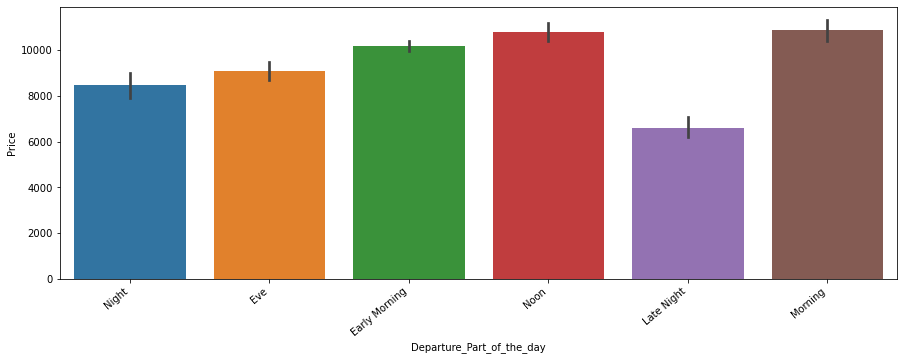

In [64]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Departure_Part_of_the_day'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [65]:
#from the above plot we can see that Morning and Noon flights are expensive and Late Night flights are cheaper

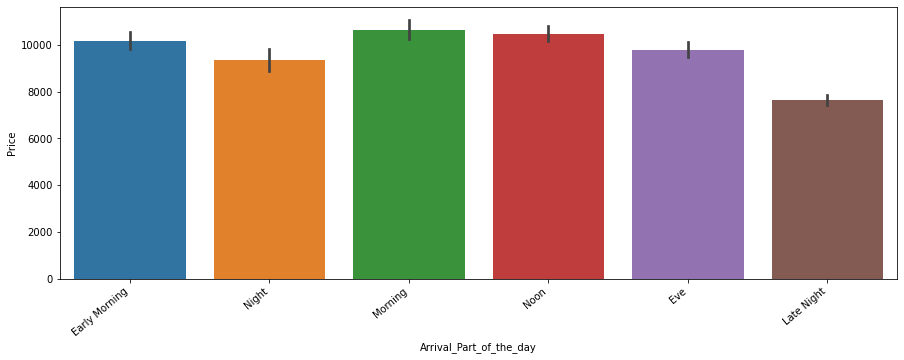

In [66]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Arrival_Part_of_the_day'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [4]:
#Late flights are cheap and morning flight prices are high 

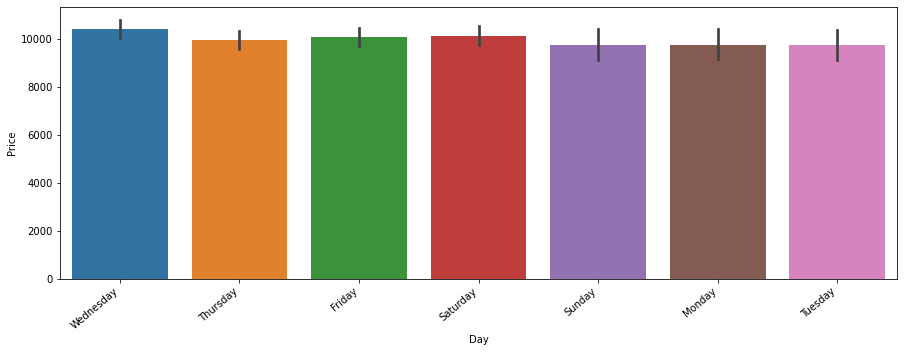

In [67]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Day'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

In [69]:
#from the above plot we can see that there is not much difference in prices

In [70]:
df.columns

Index(['Airline', 'Source City', 'Destination City', 'Stops', 'Price',
       'Duration_in_Minutes', 'Next_day_Arrival', 'Depature_hour',
       'Arrival_hour', 'Departure_Part_of_the_day', 'Arrival_Part_of_the_day',
       'Day', 'Days_priors_booking'],
      dtype='object')

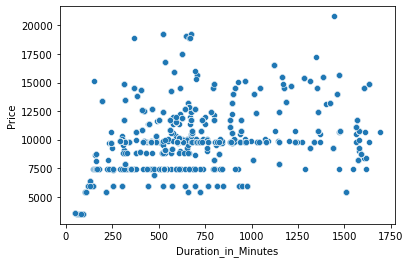

In [71]:
#Lets check this column againt our target variable
sns.scatterplot(x = 'Duration_in_Minutes', y ='Price' , data  = df)
plt.show()

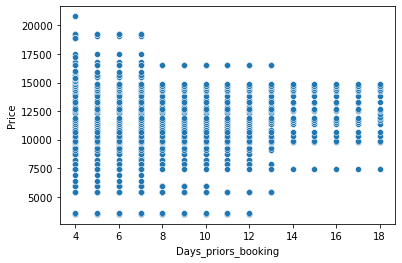

In [72]:
#Lets check this column againt our target variable
sns.scatterplot(x = 'Days_priors_booking', y ='Price' , data  = df)
plt.show()

## We have seven questions to answer our client

## 1. Do airfares change frequently?

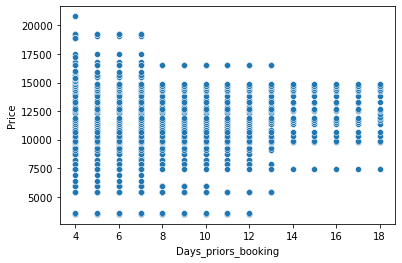

In [73]:
#Lets check this column againt our target variable
sns.scatterplot(x = 'Days_priors_booking', y ='Price' , data  = df)
plt.show()

From the above plot we can see that airfares change frequently

## 2. Do they move in small increments or in large jumps?

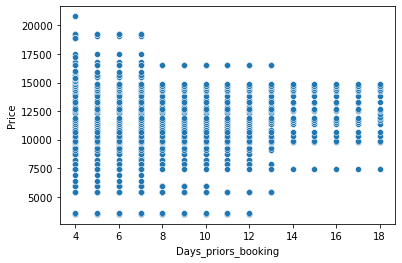

In [74]:
#Lets check this column againt our target variable
sns.scatterplot(x = 'Days_priors_booking', y ='Price' , data  = df)
plt.show()

Yes,they move in large jumps

## 3. Do they tend to go up or down over time?

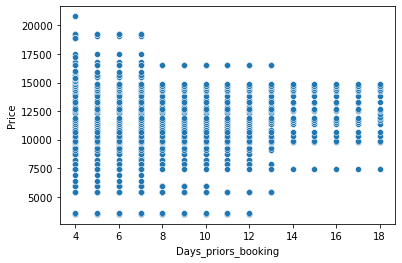

In [75]:
#Lets check this column againt our target variable
sns.scatterplot(x = 'Days_priors_booking', y ='Price' , data  = df)
plt.show()

They usally tend go down over time

## 4. What is the best time to buy so that the consumer can save the most by taking the least risk?

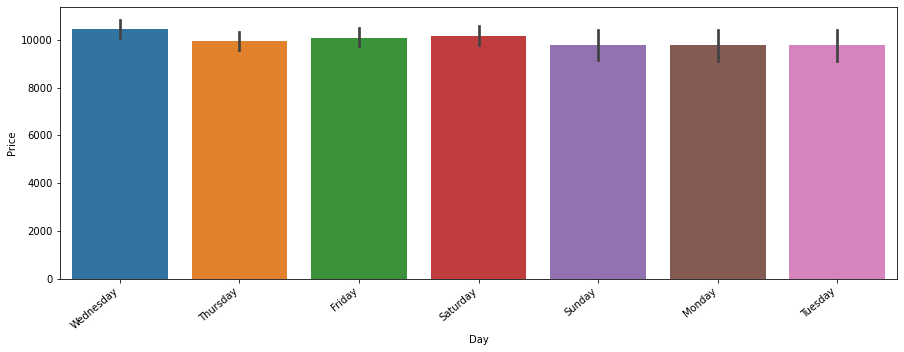

In [76]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Day'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

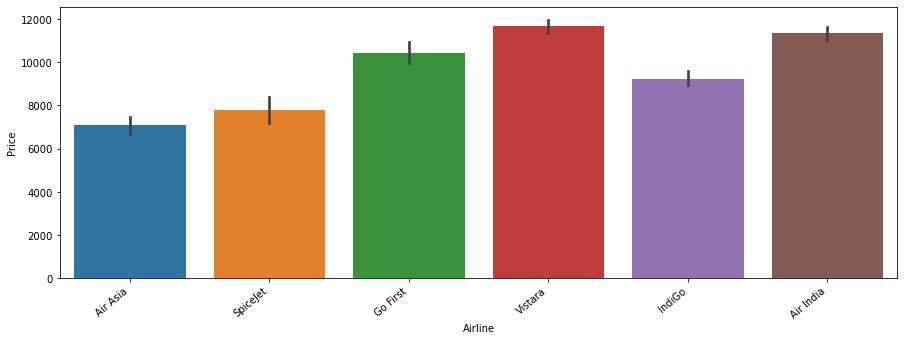

In [77]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Airline'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

Going on Tuesday and choosing Air Asia can reduce the money

## 5. Does price increase as we get near to departure date?

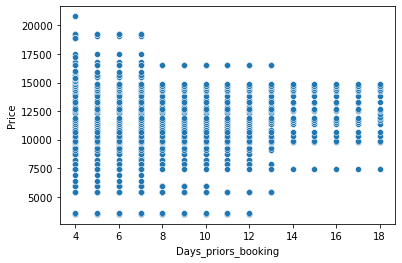

In [78]:
#Lets check this column againt our target variable
sns.scatterplot(x = 'Days_priors_booking', y ='Price' , data  = df)
plt.show()

Yes, booking prior can save some money

## 6. Is Indigo cheaper than Jet Airways? 

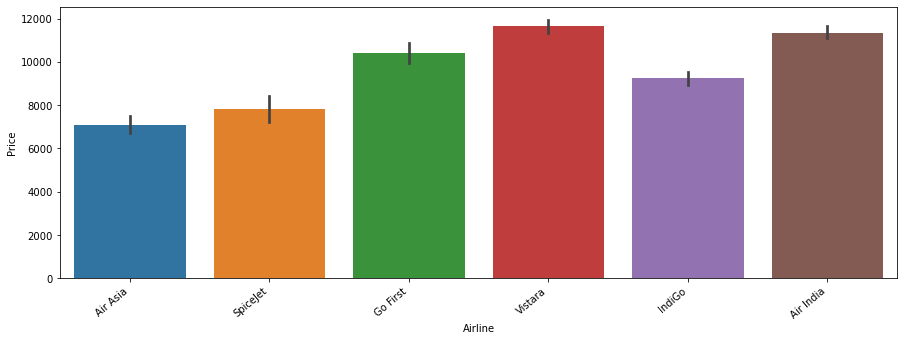

In [79]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Airline'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

No,indigo flights are not cheaper than spicejet

## 7. Are morning flights expensive?

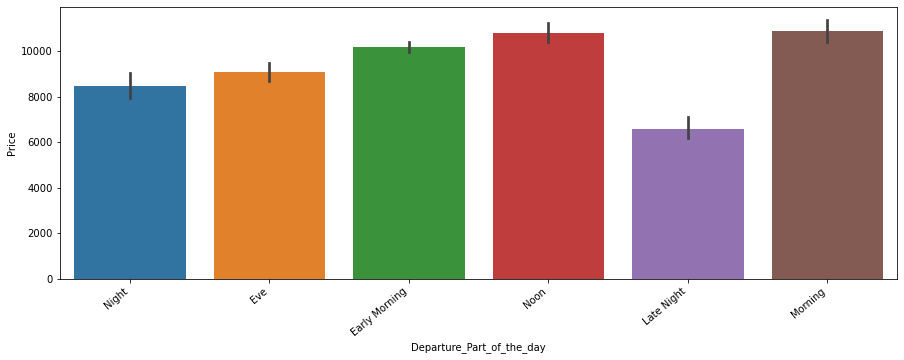

In [80]:
#Lets check this column againt our target variable
plt.figure(figsize= (15,5))
col1 = sns.barplot(x = df['Departure_Part_of_the_day'] , y =df['Price'] )
col1.set_xticklabels(col1.get_xticklabels(), rotation=40, ha="right") 
plt.show()

Yes,morning flights are expensive

## Encoding the Object Columns

In [81]:
df.columns

Index(['Airline', 'Source City', 'Destination City', 'Stops', 'Price',
       'Duration_in_Minutes', 'Next_day_Arrival', 'Depature_hour',
       'Arrival_hour', 'Departure_Part_of_the_day', 'Arrival_Part_of_the_day',
       'Day', 'Days_priors_booking'],
      dtype='object')

In [82]:
#we need convert the above columns one-hot encoder, since they are not ordinal values
#and also columns contains more than 2 unique values

one_hot_columns = ['Airline', 'Destination City','Source City','Stops', 'Departure_Part_of_the_day',
       'Arrival_Part_of_the_day',"Day","Next_day_Arrival"]
df_new = pd.get_dummies(data = df,columns=one_hot_columns)

In [83]:
df_new.shape

(1611, 46)

In [84]:
df_new.head()

,Price,Duration_in_Minutes,Depature_hour,Arrival_hour,Days_priors_booking,Airline_Air Asia,Airline_Air India,Airline_Go First,Airline_IndiGo,Airline_SpiceJet,...,Arrival_Part_of_the_day_Noon,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Next_day_Arrival_No,Next_day_Arrival_Yes
0,7410.0,475.0,23,7,4,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,7410.0,685.0,20,8,4,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,7410.0,925.0,5,21,4,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,7412.0,155.0,5,7,4,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,7412.0,160.0,7,10,4,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


## Scaling the Data

In [85]:
#lets split our x and y column before scaling
#x and y spitting
Y = df_new['Price']
X = df_new.drop('Price',axis = 1)

In [86]:
X.shape

(1611, 45)

In [87]:
#Lets scale the data using standard scaler
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),columns= X.columns)
scaled_X.head()

,Duration_in_Minutes,Depature_hour,Arrival_hour,Days_priors_booking,Airline_Air Asia,Airline_Air India,Airline_Go First,Airline_IndiGo,Airline_SpiceJet,Airline_Vistara,...,Arrival_Part_of_the_day_Noon,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Next_day_Arrival_No,Next_day_Arrival_Yes
0,-0.463273,2.125164,-1.370853,-1.074835,3.280110,-0.544112,-0.307294,-0.647598,-0.288772,-0.543154,...,-0.502714,-0.47051,-0.288772,-0.446714,-0.288772,-0.494951,-0.288772,1.857492,-1.338666,1.338666
1,0.051397,1.548211,-1.182788,-1.074835,3.280110,-0.544112,-0.307294,-0.647598,-0.288772,-0.543154,...,-0.502714,-0.47051,-0.288772,-0.446714,-0.288772,-0.494951,-0.288772,1.857492,-1.338666,1.338666
2,0.639591,-1.336554,1.262053,-1.074835,3.280110,-0.544112,-0.307294,-0.647598,-0.288772,-0.543154,...,-0.502714,-0.47051,-0.288772,-0.446714,-0.288772,-0.494951,-0.288772,1.857492,0.747012,-0.747012
3,-1.247531,-1.336554,-1.370853,-1.074835,-0.304868,-0.544112,-0.307294,-0.647598,3.462937,-0.543154,...,-0.502714,-0.47051,-0.288772,-0.446714,-0.288772,-0.494951,-0.288772,1.857492,0.747012,-0.747012
4,-1.235277,-0.951919,-0.806659,-1.074835,-0.304868,-0.544112,3.254217,-0.647598,-0.288772,-0.543154,...,-0.502714,-0.47051,-0.288772,-0.446714,-0.288772,-0.494951,-0.288772,1.857492,0.747012,-0.747012


In [88]:
#now our data is scaled using standard scaler

## PCA (Principal Component Analysis):

In [89]:
#we need to use pca becuase we have 38 columns in this dataset which is very high

In [90]:
#we should always use scaled data for performing the PCA

In [91]:
#we have 38 columns excluding target variable
scaled_X.shape

(1611, 45)

In [92]:
#first lets TEST out percentage of data that we will obtain after PCA
testpca = PCA()
test_x = testpca.fit(scaled_X)

In [93]:
#now lets out cumulative score 
cum_score = np.cumsum(test_x.explained_variance_ratio_)*100
cum_score  

array([ 11.85435681,  20.33212103,  27.19134463,  33.54814645,
        39.79137941,  44.91951287,  49.45315102,  53.3627219 ,
        57.03259885,  60.13965645,  63.14838234,  66.04465798,
        68.81446557,  71.5597438 ,  74.1388537 ,  76.62949857,
        79.0596651 ,  81.46719704,  83.66699807,  85.79534175,
        87.85028802,  89.79316579,  91.51750638,  93.1889386 ,
        94.70299481,  96.09435473,  97.25038769,  98.30749264,
        99.24753994,  99.89943604,  99.95126808,  99.98809376,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        ])

In [94]:
#lets check how many columns gives 90% of variance
s = np.argmax(cum_score > 90)
print("Number of components expaining 90% of variance is :", s)

Number of components expaining 90% of variance is : 22


In [95]:
#lets check how many columns gives 95% of variance
s = np.argmax(cum_score > 95)
print("Number of components expaining 95% of variance is :", s)

Number of components expaining 95% of variance is : 25


In [96]:
#now we have seen that how much data will be lost based number of columns

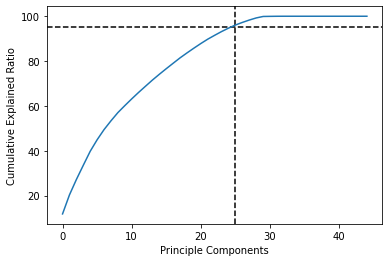

In [97]:
#lets plot the graph for graphical understanding
plt.ylabel('Cumulative Explained Ratio')
plt.xlabel('Principle Components')

plt.axvline(x = s, color = 'k', linestyle = '--')
plt.axhline(y = 95, color = 'k', linestyle = '--')

plt.plot(cum_score)
plt.show()

#### From the above plot we can see that for 25 columns 95% of data will be retrived

In [98]:
#lets perform the PCA with 24 columns
Final_pca = PCA(n_components= 25)

pca_x = pd.DataFrame(Final_pca.fit_transform(scaled_X))

In [99]:
#lets create a datafram
pca_x.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.149937,1.864914,-3.892351,-1.374993,-1.639341,0.066461,0.551029,1.662039,-0.304338,0.320975,...,2.119278,1.144871,-1.009514e-13,-0.197787,1.036613,-1.275532,1.161210,-0.259676,-1.642735,-0.102537
1,3.165569,1.599564,-3.067477,-1.083472,-1.631077,-0.766570,0.861333,0.449526,-0.430040,1.130456,...,0.291773,0.365065,-2.419511e-14,-0.408467,-0.014941,1.261634,0.985970,-2.166046,-0.548277,-0.403672
2,-0.791918,1.963852,-0.214012,-0.986673,-1.934117,0.303495,-2.767788,3.031429,0.555515,-0.785993,...,0.005372,0.310695,-2.446467e-14,-1.377275,0.339613,1.134381,0.205608,-2.426469,-0.104268,-1.789628
3,-0.486164,1.805325,-1.343228,-2.382224,-0.846197,0.600718,0.334233,1.962197,1.704739,-1.101626,...,-2.893291,-0.600962,6.611191e-14,-1.096893,0.626089,-0.990294,-1.047570,-1.438415,-2.354863,1.507278
4,-0.683117,1.441120,-1.466330,-0.856984,-2.294408,0.901264,0.515789,1.470200,2.530961,-1.484835,...,-2.593111,-0.745832,6.680996e-14,-2.398234,-1.242048,-0.705842,0.469962,1.426735,0.898428,-0.395288


In [100]:
print("variance is : {}".format(np.sum(Final_pca.explained_variance_ratio_)))

variance is : 0.9470299481410226


In [101]:
pca_x.shape

(1611, 25)

## Best random state

In [102]:
max_r2score = 0
rand_state = 0
for i in range(1,200):
    x_train,x_test,y_train,y_test = train_test_split(pca_x,Y,test_size=.22,random_state= i )
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    pred = lr.predict(x_test)
    r2 = r2_score(y_test,pred)
    if r2 > max_r2score:
        max_r2score = r2
        rand_state = i
print('Best r2 score is {} on random state {}'.format(max_r2score,rand_state)) 

Best r2 score is 0.6951706950402602 on random state 140


In [103]:
print('We got our best randoms sate as :',rand_state)

We got our best randoms sate as : 140


In [104]:
#Lets split for train and test data
x_train,x_test,y_train,y_test = train_test_split(pca_x,Y,test_size=.22,random_state= rand_state )

In [105]:
lrg = LinearRegression()
lrg.fit(x_train,y_train)
pr =lrg.predict(x_test)
print("r2_score of linear refression is :", r2_score(y_test,pr))
print('Error :')
print('mean absolute error :',mean_absolute_error(y_test,pred))
print('mean squared error : ', mean_squared_error(y_test,pred))
print('root mean squared error :',np.sqrt(mean_squared_error(y_test,pred)))

r2_score of linear refression is : 0.6951706950402602
Error :
mean absolute error : 3597.4374685695016
mean squared error :  19357960.20887996
root mean squared error : 4399.768199448689


## Model selection :

In [106]:
#lets Choose r2 score of below four Models
dtc = DecisionTreeRegressor()
knn = KNeighborsRegressor(n_neighbors=5)
rf = RandomForestRegressor()
ada = AdaBoostRegressor()

In [107]:
#checking each model with Cross val score
model_list = [dtc,knn,rf,ada]
least_difference = []
for m in model_list:
    m.fit(x_train,y_train)
    pred = m.predict(x_test)
    cvs = cross_val_score(m,pca_x,Y,cv =5)
    print('\n')
    print(m)
    print('Scores :')
    print('r2 score:',r2_score(y_test,pred))
    print('Cross Val score :',cvs.mean())
    print('Error :')
    print('mean absolute error :',mean_absolute_error(y_test,pred))
    print('mean squared error : ', mean_squared_error(y_test,pred))
    print('root mean squared error :',np.sqrt(mean_squared_error(y_test,pred)))
    print('Difference :')
    difference = np.abs(r2_score(y_test,pred) - cvs.mean())
    print('Diffrence between cross val score and r2 score is : {0:.2f}'.format(difference))
    least_difference.append((m,'Diffrence between cross val score and r2 score error is : {0:.2f}'.format(difference)))



DecisionTreeRegressor()
Scores :
r2 score: 0.8127532004570739
Cross Val score : -2.617234370957825
Error :
mean absolute error : 643.9859154929577
mean squared error :  2300128.842253521
root mean squared error : 1516.6175662484993
Difference :
Diffrence between cross val score and r2 score is : 3.43


KNeighborsRegressor()
Scores :
r2 score: 0.8405881495596268
Cross Val score : -0.1285775537056941
Error :
mean absolute error : 880.4056338028169
mean squared error :  1958205.9393802818
root mean squared error : 1399.359117374908
Difference :
Diffrence between cross val score and r2 score is : 0.97


RandomForestRegressor()
Scores :
r2 score: 0.9112200542997836
Cross Val score : -0.9324741693884183
Error :
mean absolute error : 651.2223661971831
mean squared error :  1090567.71179662
root mean squared error : 1044.3025001390258
Difference :
Diffrence between cross val score and r2 score is : 1.84


AdaBoostRegressor()
Scores :
r2 score: 0.7440735156979998
Cross Val score : -0.65281737

## RandomForestRegressor giving the best Score of 91%

## Hyperparameter Tuning:

In [109]:
#lets use random forest regressor
#it takes a lot lot of time approx 6 hours, so commented after
parameters = {'n_estimators' : [100,200,300],'criterion':['mse','mae'],'max_features':['auto','sqrt','log2']}
gsvrf = RandomizedSearchCV(rf, parameters, cv=5,scoring="r2")
gsvrf.fit(x_train,y_train)
print(gsvrf.best_score_)
print(gsvrf.best_params_)

0.8515586124486496
{'n_estimators': 100, 'max_features': 'auto', 'criterion': 'mse'}


## Creating a Final Model as RandomForestRegressor

In [110]:
final_model_rf = RandomForestRegressor(n_estimators= 100,criterion= 'mse',max_features = 'auto')
final_model_rf.fit(x_train,y_train)
final_pred = final_model_rf.predict(x_test)
cvs = cross_val_score(final_model_rf,pca_x,Y,cv =5)
print('\n')
print('Scores :')
print('r2 score:',r2_score(y_test,final_pred))
print('Cross Val score :',cvs.mean())
print('Error :')
print('mean absolute error :',mean_absolute_error(y_test,final_pred))
print('mean squared error : ', mean_squared_error(y_test,final_pred))
print('root mean squared error :',np.sqrt(mean_squared_error(y_test,final_pred)))
print('Difference :')
difference = np.abs(r2_score(y_test,final_pred) - cvs.mean())
print('Diffrence between cross val score and r2 score is : {0:.2f}'.format(difference))
least_difference.append((m,'Diffrence between cross val score and r2 score is : {0:.2f}'.format(difference)))



Scores :
r2 score: 0.9112014590749229
Cross Val score : -0.7503076344554618
Error :
mean absolute error : 639.3714366197183
mean squared error :  1090796.134461972
root mean squared error : 1044.4118605521348
Difference :
Diffrence between cross val score and r2 score is : 1.66


## Saving the model:

In [111]:
#serialization using joblib
import joblib
joblib.dump(final_model_rf,'Flight_Price_Prediction.obj')

['Flight_Price_Prediction.obj']

In [112]:
Flight_Price = joblib.load('Flight_Price_Prediction.obj')

In [113]:
s_pred = Flight_Price.predict(x_test)

In [114]:
r2_score(y_test,s_pred)

0.9112014590749229

our r2_score is 91.12% percent

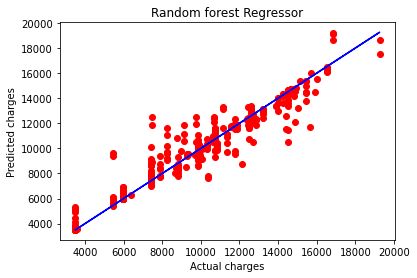

In [115]:
#lets plot y_test vs predicted 

plt.figure(figsize=(6,4))
plt.scatter(x = y_test,y = s_pred,color = 'r')
plt.plot(y_test,y_test,color = 'b')
plt.xlabel('Actual charges')
plt.ylabel('Predicted charges')
plt.title('Random forest Regressor')
plt.show()

we can see that values are very close to the line

## Conclusion

In [116]:
#lets make a dataframe of actual answers vs predicted answers
conclusion = pd.DataFrame((Flight_Price.predict(x_test)[:],y_test[:]),index= ['Predicted','Actual'])
conclusion

,0,1,2,3,4,5,6,7,8,9,...,345,346,347,348,349,350,351,352,353,354
Predicted,13652.56,12983.39,11904.41,11029.65,9302.93,13155.54,9690.53,3703.46,3644.16,9661.23,...,9730.46,9088.37,9576.42,10442.53,8120.3,10376.8,14751.12,10724.69,13027.86,14690.0
Actual,14524.00,12581.00,9726.00,9830.00,10744.00,13206.00,9840.00,3498.00,3498.00,5425.00,...,9840.00,9828.00,9311.00,10744.00,8778.0,10834.0,14690.00,10744.00,12581.00,14690.0


91% of Our answers are correct, and the model is also not overfitted